# Windy Gridworld

`通过这个实验，了解Model Free的Temporal Difference的On-Policy Controlling，SARSA。`

所有的实验源代码都在`lib`目录下，来自[dennybritz](https://github.com/dennybritz/reinforcement-learning)，这里只做解读和归总。

## 实验目录

- [Gridworld](https://applenob.github.io/gridworld.html)：对应MDP的Dynamic Programming
- [Blackjack](https://applenob.github.io/black_jack.html)：对应Model Free的Monte Carlo的Planning和Controlling
- [Windy Gridworld](https://applenob.github.io/windy_gridworld.html)：对应Model Free的Temporal Difference的On-Policy Controlling，SARSA。
- [Cliff Walking](https://applenob.github.io/cliff_walking.html)：对应Model Free的Temporal Difference的Off-Policy Controlling，Q-learning。
- [Mountain Car](https://applenob.github.io/mountain_car.html)：对应Q-Learning with Linear Function Approximation。
- [Atari](https://applenob.github.io/atari.html)：对应Deep-Q Learning。


## 本文目录

- [问题介绍](#问题介绍)
- [SARSA](#SARSA)

## 问题介绍

![](https://github.com/applenob/rl_learn/raw/master/res/windy_gw.png)

类似于Gridworld，agent需要找到Terminate点，对应图中也就是在$S$点到$G$点。但是这个问题加入一个新的挑战，即会有自下而上往上吹的风，上图中横坐标的个数就代表风力。

- 动作集：上下左右。
- 奖励：每走一步减一分，到达终点加一分。
- 这个问题实际上也可以用环境的模型来解决：在某个状态采取某个动作，计算进风力，你可以知道下一时刻会到哪里。但这里选择用用Model Free的方法解决。

```python
import gym
import numpy as np
import sys
from gym.envs.toy_text import discrete

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

class WindyGridworldEnv(discrete.DiscreteEnv):

    metadata = {'render.modes': ['human', 'ansi']}

    def _limit_coordinates(self, coord):
        """返回合法的坐标"""
        coord[0] = min(coord[0], self.shape[0] - 1)
        coord[0] = max(coord[0], 0)
        coord[1] = min(coord[1], self.shape[1] - 1)
        coord[1] = max(coord[1], 0)
        return coord

    def _calculate_transition_prob(self, current, delta, winds):
        """采用某个action以后，下一个时刻的状态"""
        new_position = np.array(current) + np.array(delta) + np.array([-1, 0]) * winds[tuple(current)]
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        is_done = tuple(new_position) == (3, 7)  # 终点坐标
        return [(1.0, new_state, -1.0, is_done)]

    def __init__(self):
        self.shape = (7, 10)

        nS = np.prod(self.shape)
        nA = 4

        # Wind strength
        # 风力已知
        winds = np.zeros(self.shape)
        winds[:,[3,4,5,8]] = 1
        winds[:,[6,7]] = 2

        # Calculate transition probabilities
        P = {}
        for s in range(nS):
            # numpy.unravel_index：输入index（一维）和矩阵的shape，返回这个index对应在矩阵中的多维的index
            position = np.unravel_index(s, self.shape)
            P[s] = { a : [] for a in range(nA) }
            P[s][UP] = self._calculate_transition_prob(position, [-1, 0], winds)
            P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1], winds)
            P[s][DOWN] = self._calculate_transition_prob(position, [1, 0], winds)
            P[s][LEFT] = self._calculate_transition_prob(position, [0, -1], winds)

        # We always start in state (3, 0)
        isd = np.zeros(nS)
        # np.ravel_multi_index是numpy.unravel_index的逆操作
        isd[np.ravel_multi_index((3,0), self.shape)] = 1.0

        super(WindyGridworldEnv, self).__init__(nS, nA, P, isd)

    def _render(self, mode='human', close=False):
        if close:
            return

        outfile = StringIO() if mode == 'ansi' else sys.stdout

        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            # print(self.s)
            if self.s == s:
                output = " x "
            elif position == (3,7):
                output = " T "
            else:
                output = " o "

            if position[1] == 0:
                output = output.lstrip()
            if position[1] == self.shape[1] - 1:
                output = output.rstrip()
                output += "\n"

            outfile.write(output)
        outfile.write("\n")
```

In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys
from collections import defaultdict
from lib.envs.windy_gridworld import WindyGridworldEnv
from lib import plotting

matplotlib.style.use('ggplot')

试着往右走一步，会发生什么情况：

In [2]:
env = WindyGridworldEnv()

print(env.reset())
env.render()

print(env.step(1))
env.render()

30
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o

(31, -1.0, False, {'prob': 1.0})
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  x  o  o  o  o  o  T  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o



## SARSA
![](https://github.com/applenob/rl_learn/raw/master/res/sarsa_est.png)

SARSA相当于差分版的On-Policy Monte-Carlo Control。

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [4]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        alpha: TD learning rate.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))

    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        
        # MC是抽完一整条episode，再用这条episode进行更新。
        # SARSA在抽episode的每一步都要进行更新。
        
        # One step in the environment
        # itertools.count()：从0开始计数
        for t in itertools.count():
            # Take a step
            next_state, reward, done, _ = env.step(action)
            
            # Pick the next action
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            td_target = reward + discount_factor * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
    
            if done:
                break
                
            action = next_action
            state = next_state        
    
    return Q, stats

价值函数更新：$Q(S,A)\leftarrow Q(S,A)+\alpha[R+\gamma Q(S',A')-Q(S, A)]$

对应代码：
```python
td_target = reward + discount_factor * Q[next_state][next_action]
td_delta = td_target - Q[state][action]
Q[state][action] += alpha * td_delta
```
可以说是一一对应。

In [5]:
Q, stats = sarsa(env, 200)

Episode 200/200.

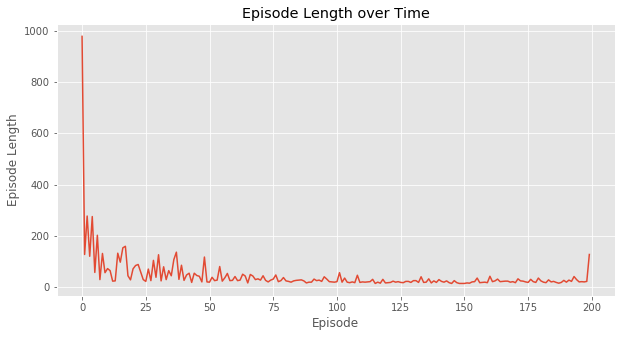

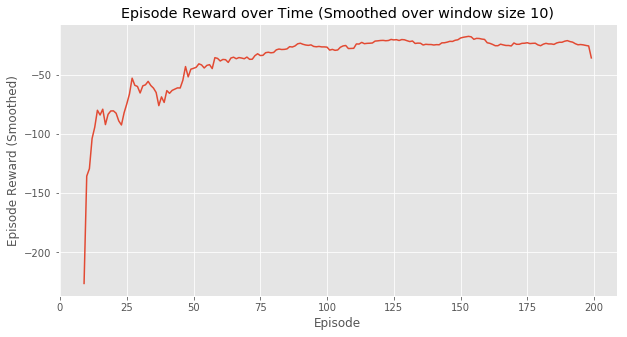

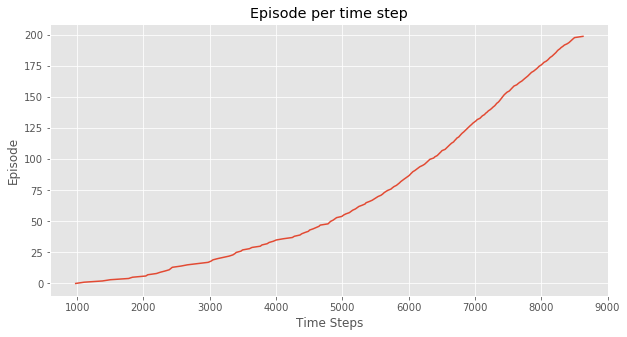

(<matplotlib.figure.Figure at 0x7fcf06b0e048>,
 <matplotlib.figure.Figure at 0x7fcf06ab7a58>)

In [6]:
plotting.plot_episode_stats(stats)